Try training on GHZ state using data in complete set of discrete bases.

In [1]:
import numpy as np
import torch

In [2]:
from models import MPS, ComplexTensor

In [3]:
L=4
local_dim=2
bond_dim=2

In [4]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

Samples_tr: lists indices of the observed basis states at each measurement.

settings: array of corresponding angles

In [5]:
fname_settings = "settings_ghz_plus_all_discrete_bases_angles_L=%d.npy"%L
fname_samples = "samples_ghz_plus_all_discrete_bases_angles_L=%d.npy"%L
samples = np.load(fname_samples)
samples_tr = torch.tensor((1-samples)/2).to(torch.long)
settings = np.load(fname_settings)

In [6]:
theta = torch.tensor(settings[...,0],dtype=torch.float32)
phi = torch.tensor(settings[...,1],dtype=torch.float32)

In [7]:
from qtools import pauli_exp

In [8]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

In [9]:
from torch.utils.data import TensorDataset, DataLoader

In [10]:
from models import MeasurementDataset, ComplexTensor

In [11]:
ds = MeasurementDataset(samples=samples_tr,rotations=U)

In [12]:
batch_size = 256
lr = .001

In [13]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [14]:
losses = []

Number of epochs of training

In [15]:
eps = 3

In [16]:
nstep=1

In [17]:
max_sv = None
cutoff=1e-10

In [18]:
amp1 = []
amp2 = []

In [19]:
for ep in range(eps):
    for step, inputs in enumerate(dl):
        #get torch tensors representing measurement outcomes, and corresponding local unitaries
        spinconfig = inputs['samples']
        rot = inputs['rotations']
        rotations = ComplexTensor(rot['real'], rot['imag'])
        #forward sweep across the chain
        for i in range(L-1):
            for __ in range(nstep):
                psi.do_sgd_step(i, spinconfig,
                                        rotation=rotations,cutoff=cutoff,normalize='left',max_sv_to_keep=max_sv, 
                                       learning_rate = lr)   
        for i in range(L-2, -1,-1):
            for __ in range(nstep):
                psi.do_sgd_step(i, spinconfig,
                                        rotation=rotations,cutoff=cutoff,normalize='right',max_sv_to_keep=max_sv, 
                                       learning_rate = lr)   
        with torch.no_grad():
            losses.append(psi.nll_loss(spinconfig,rotation=rotations))
            
        #check the relative phase between the two relevant basis states
        s1 = torch.tensor([1,0]* (L//2),dtype=torch.long)
        s2 = torch.tensor([0,1] * (L//2),dtype=torch.long)
        a1 = psi.amplitude_normalized(s1).numpy().item()
        a2 = psi.amplitude_normalized(s2).numpy().item()
        amp1.append(a1)
        amp2.append(a2)
        
        
    print("finished epoch %d" % ep)

        

finished epoch 0
finished epoch 1
finished epoch 2


In [20]:
import matplotlib.pyplot as plt

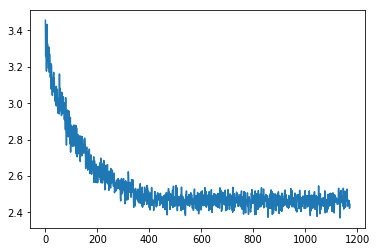

In [21]:
%matplotlib inline
plt.plot(losses)

In [22]:
amp1 = np.asarray(amp1)
amp2 = np.asarray(amp2)
phi1 = np.angle(amp1,deg=True)
phi2 = np.angle(amp2,deg=True)
dphi = phi1-phi2

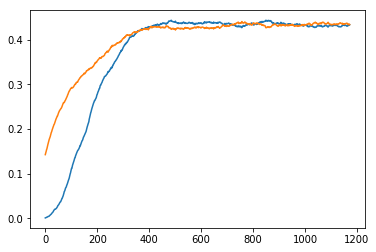

In [23]:
fig, ax = plt.subplots()
plt.plot(np.abs(amp1)**2, label="10")
plt.plot(np.abs(amp2)**2, label="01")

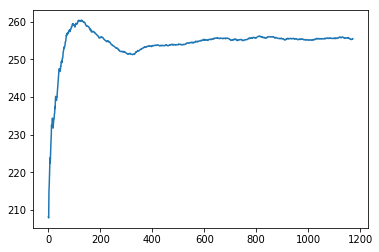

In [24]:
fig, ax = plt.subplots()
plt.plot(dphi)

In [25]:
from tools import generate_binary_space

In [26]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [27]:
with torch.no_grad():
    for i in range(len(basis)):
        print("{0} has probability {1:.4f}".format(basis[i], psi.prob_normalized(basis[i]).item()))

tensor([1, 1, 1, 1]) has probability 0.0077
tensor([1, 1, 1, 0]) has probability 0.0100
tensor([1, 1, 0, 1]) has probability 0.0098
tensor([1, 1, 0, 0]) has probability 0.0081
tensor([1, 0, 1, 1]) has probability 0.0108
tensor([1, 0, 1, 0]) has probability 0.4335
tensor([1, 0, 0, 1]) has probability 0.0084
tensor([1, 0, 0, 0]) has probability 0.0102
tensor([0, 1, 1, 1]) has probability 0.0116
tensor([0, 1, 1, 0]) has probability 0.0085
tensor([0, 1, 0, 1]) has probability 0.4338
tensor([0, 1, 0, 0]) has probability 0.0103
tensor([0, 0, 1, 1]) has probability 0.0089
tensor([0, 0, 1, 0]) has probability 0.0107
tensor([0, 0, 0, 1]) has probability 0.0096
tensor([0, 0, 0, 0]) has probability 0.0081


In [28]:
with torch.no_grad():
    for i in range(len(basis)):
        a = psi.amplitude_normalized(basis[i])
        print("{0} has amplitude {1:.4f} + i{2:.4f}".format(basis[i], a.real.item(), a.imag.item()))

tensor([1, 1, 1, 1]) has amplitude -0.0877 + i0.0005
tensor([1, 1, 1, 0]) has amplitude -0.0965 + i-0.0257
tensor([1, 1, 0, 1]) has amplitude 0.0981 + i-0.0138
tensor([1, 1, 0, 0]) has amplitude 0.0900 + i0.0062
tensor([1, 0, 1, 1]) has amplitude 0.1008 + i0.0250
tensor([1, 0, 1, 0]) has amplitude -0.4395 + i0.4902
tensor([1, 0, 0, 1]) has amplitude -0.0913 + i-0.0077
tensor([1, 0, 0, 0]) has amplitude -0.0987 + i-0.0219
tensor([0, 1, 1, 1]) has amplitude -0.1068 + i0.0144
tensor([0, 1, 1, 0]) has amplitude -0.0922 + i-0.0024
tensor([0, 1, 0, 1]) has amplitude -0.3646 + i-0.5485
tensor([0, 1, 0, 0]) has amplitude 0.1008 + i-0.0122
tensor([0, 0, 1, 1]) has amplitude 0.0940 + i0.0056
tensor([0, 0, 1, 0]) has amplitude 0.0998 + i0.0277
tensor([0, 0, 0, 1]) has amplitude -0.0968 + i0.0145
tensor([0, 0, 0, 0]) has amplitude -0.0899 + i-0.0010


In [29]:
a1 = psi.amplitude_normalized(torch.tensor([1,0,1,0])).numpy().item()
a2 = psi.amplitude_normalized(torch.tensor([0,1,0,1])).numpy().item()

In [30]:
phi1=np.angle(a1, deg=True)

In [31]:
phi2=np.angle(a2, deg=True)